# Gradient Descent

решение уравнений методом вариаций и градиентного спуска

In [79]:
import math
import numpy as np
import pandas as pd

%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt

In [80]:
import physics as ph
from Sun import SSM18 as s

In [81]:
pi = math.pi
Z = s.Z

In [82]:
def load_model(epoch):
    filename = 'Mass/1epoch%.02d.csv' % epoch
    return pd.read_csv(filename)
epoch = 0
df = load_model(epoch)
dimM = len(df.index)
df

,Unnamed: 0,Mass,Radius,Temperature,Density,Luminosity,Hydrogen,Opacity,Convection,Pressure,Velocity
0,0,0.000000e+00,0.000000e+00,1.333000e+07,94.554471,0.000000e+00,0.732,1.318613,0.0,1.730205e+17,8.561869e-11
1,1,1.989737e+30,1.720827e+09,1.323295e+07,93.267398,2.371017e+31,0.732,1.337635,0.0,1.694228e+17,8.186134e-11
2,2,3.979475e+30,2.170742e+09,1.317560e+07,92.506463,4.667612e+31,0.732,1.348390,0.0,1.673123e+17,7.971258e-11
3,3,5.969212e+30,2.487796e+09,1.312752e+07,91.867973,6.909218e+31,0.732,1.357124,0.0,1.655511e+17,7.795029e-11
4,4,7.958950e+30,2.741213e+09,1.308464e+07,91.297969,9.104061e+31,0.732,1.364692,0.0,1.639865e+17,7.640787e-11
...,...,...,...,...,...,...,...,...,...,...,...
996,996,1.981778e+33,5.478443e+10,8.884676e+05,0.065450,2.461129e+33,0.732,6.506261,1.0,7.982444e+12,2.801593e-22
997,997,1.983768e+33,5.565851e+10,7.779882e+05,0.053620,2.461129e+33,0.732,5.330260,1.0,5.726433e+12,5.617357e-23
998,998,1.985758e+33,5.672587e+10,6.475668e+05,0.040707,2.461129e+33,0.732,4.046600,1.0,3.618575e+12,6.097868e-24
999,999,1.987748e+33,5.818398e+10,4.769614e+05,0.025719,2.461129e+33,0.732,2.556699,1.0,1.683936e+12,1.506867e-25


In [83]:
x = df['Hydrogen'].values
m = df['Mass'].values
d = df['Density'].values
t = df['Temperature'].values
# v = df['Velocity'].values

In [84]:
r = np.zeros(dimM)
l = np.zeros(dimM)
p = np.zeros(dimM)
k = np.zeros(dimM)
v = np.zeros(dimM)

In [85]:
d1 = d.copy()
t1 = t.copy()
x1 = x.copy()
# Вычисляем величины r,l,p,k,c,v из x,m,d,t
r[0] = 0.
l[0] = 0.
for i in range(1, dimM):
    r[i] = pow(pow(r[i-1], 3) + 3*(m[i] - m[i-1])/4/pi/d1[i-1], 1/3) 
    l[i] = l[i-1] + (m[i] - m[i-1])*ph.Etot(0.5*(d1[i]+d1[i-1]), 0.5*(t1[i]+t1[i-1]), x1[i], 1 - Z - x1[i], Z)
for i in range(dimM):
    X = x1[i]
    Y = 1 - Z -X
    p[i] = ph.Pressure(d1[i], t1[i], X, Y, Z)
    k[i] = ph.opacity(d1[i], t1[i], X, Y, Z)
    v[i] = 4*ph.m_prot*ph.Etot(d1[i], t1[i], X, Y, Z)/X/ph.dEpp*ph.year

In [97]:
a = np.zeros(dimM) # градиент давления
da = np.zeros(dimM) # несоответствие градиента давления
b = np.zeros(dimM) # градиент температуры
br = np.zeros(dimM) # градиент температуры при радиации
bc = np.zeros(dimM) # градиент температуры при конвекции
db = np.zeros(dimM) # несоответствие градиента температуры 

In [98]:
N = 40 #
M = 25
print('N*M+1 = dimM is '+ str(N*M+1 == dimM))

N*M+1 = dimM is True


In [114]:
def Error():
    # Вычисляем величины r,l,p,k,c,v из x1,m,d1,t1
    r[0] = 0.
    l[0] = 0.
    for i in range(1, dimM):
        r[i] = pow(pow(r[i-1], 3) + 3*(m[i] - m[i-1])/4/pi/d1[i-1], 1/3) 
        l[i] = l[i-1] + (m[i] - m[i-1])*ph.Etot(0.5*(d1[i]+d1[i-1]), 0.5*(t1[i]+t1[i-1]), x1[i], 1 - Z - x1[i], Z)
    for i in range(dimM):
        X = x1[i]
        Y = 1 - Z - X
        p[i] = ph.Pressure(d1[i], t1[i], X, Y, Z)
        k[i] = ph.opacity(d1[i], t1[i], X, Y, Z)
        v[i] = 4*ph.m_prot*ph.Etot(d1[i], t1[i], X, Y, Z)/X/ph.dEpp*ph.year
    sa = 0
    sb = 0
    for i in range(1, dimM-1):
        X = x1[i]
        Y = 1 - Z - X
        mu = ph.MU(X, Y, Z)
        a[i] = -ph.G*m[i]*d1[i]/pow(r[i], 2)
        da[i] = (p[i+1] - p[i])/2/(r[i+1] - r[i]) + (p[i] - p[i-1])/2/(r[i] - r[i-1])
        br[i] = -3/16*k[i]*d1[i]*l[i]/ph.sigma/pow(t1[i], 3)/4/pi/pow(r[i], 2)
        bc[i] = -0.4*mu/ph.kB*ph.m_prot*ph.G*m[i]/pow(r[i], 2)
        if abs(br[i]) < abs(bc[i]):
            b[i] = br[i]
        else:
            b[i] = bc[i]
        db[i] = (t1[i+1] - t1[i])/2/(r[i+1] - r[i]) + (t1[i] - t1[i-1])/2/(r[i] - r[i-1])
#         sa += pow((da[i] - a[i])*(db[i] - b[i]), 2)
        sa += pow((da[i] - a[i])/6760886, 2)
        sb += pow((db[i] - b[i])/0.000324, 2)
#     print(sa, sb)
#     return 0.5*(sa/838897020508.5634 + sb/8.284019085256349e-09)
    return (sa + sb)/0.09726621893099568
#     return sa/355.3047197588518

In [115]:
def factor(i, j):
    n = abs(i - j*M)
    if n >= M:
        return 0.
    if j == 0:
        return 2.*(1. - i/M)
    return 1. - n/M

In [129]:
NG = 300 
err = np.zeros(NG)
count = 0
k0 = 0.0003
ed = np.zeros(N+1)
et = np.zeros(N+1)
x1 = df['Hydrogen'].values.copy()
d1 = df['Density'].values.copy()
t1 = df['Temperature'].values.copy()
v = df['Velocity'].values.copy()
x1 = x1*np.exp(-1e9*v)

In [130]:
count = 0
err[count] = Error()
err[count]

88.11229718915979

In [131]:
%%time
while count < NG:
    
    d2 = d1.copy()
    t2 = t1.copy()
    
    for j in range(N+1):
        for i in range(dimM):
            d1[i] = d2[i] + 0.001*factor(i, j)*d2[i]
        ed[j] = Error() - err[count]
    
    d1 = d2.copy()
    for j in range(N+1):
        for i in range(dimM):
            t1[i] = t2[i] + 0.001*factor(i, j)*t2[i]
        et[j] = Error() - err[count]   
#     print(ed, et)
    stepd = pow((ed*ed).sum(), 0.5)
    stept = pow((et*et).sum(), 0.5)
    cosd = 1.
    cost = 1.
    if (count > 0):
        cosd = (ed*ed2).sum()/stepd/stepd2
        cost = (et*et2).sum()/stept/stept2
    stepd2 = stepd
    stept2 = stept
    ed2 = ed.copy()
    et2 = et.copy()
    d1 = d2.copy()
    t1 = t2.copy()
    for i in range(dimM):
        for j in range(N+1):
            f = factor(i, j)
            d1[i] -= k0*f*ed[j]*d2[i]
            t1[i] -= k0*f*et[j]*t2[i]
    err0 = err[count]
    count += 1
    err1 = Error()
    
    err[count] = err1
    print('count=%d Error=%.2f Ratio=%.3f stepd=%.2f cosd=%.5f stept=%.2f cost=%.5f' % (count, err[count], 100*err0/err1 - 100., stepd, cosd, stept, cost))
    if err0 <= err1:
        break

count=1 Error=84.17 Ratio=4.680 stepd=1.70 cosd=1.00000 stept=6.83 cost=1.00000
count=2 Error=80.62 Ratio=4.408 stepd=1.65 cosd=0.99960 stept=6.71 cost=0.99915
count=3 Error=77.39 Ratio=4.172 stepd=1.61 cosd=0.99970 stept=6.61 cost=0.99956
count=4 Error=74.44 Ratio=3.958 stepd=1.57 cosd=0.99977 stept=6.52 cost=0.99968
count=5 Error=71.75 Ratio=3.760 stepd=1.53 cosd=0.99980 stept=6.43 cost=0.99974
count=6 Error=69.27 Ratio=3.577 stepd=1.49 cosd=0.99982 stept=6.35 cost=0.99979
count=7 Error=66.99 Ratio=3.405 stepd=1.46 cosd=0.99983 stept=6.28 cost=0.99982
count=8 Error=64.89 Ratio=3.238 stepd=1.43 cosd=0.99984 stept=6.21 cost=0.99984
count=9 Error=62.95 Ratio=3.081 stepd=1.40 cosd=0.99984 stept=6.15 cost=0.99986
count=10 Error=61.16 Ratio=2.929 stepd=1.37 cosd=0.99985 stept=6.09 cost=0.99988
count=11 Error=59.32 Ratio=3.090 stepd=1.34 cosd=0.99985 stept=6.03 cost=0.99989
count=12 Error=57.79 Ratio=2.652 stepd=1.31 cosd=0.99983 stept=6.01 cost=0.99865
count=13 Error=56.37 Ratio=2.520 step

In [132]:
df1 = pd.DataFrame({'Mass': m, 'Radius': r, 'Temperature': t1, 'Density': d1, 
          'Luminosity': l, 'Hydrogen': x1, 'Opacity': k, 'Pressure': p, 'Velocity': v})
df1

,Mass,Radius,Temperature,Density,Luminosity,Hydrogen,Opacity,Pressure,Velocity
0,0.000000e+00,0.000000e+00,1.328860e+07,96.359747,0.000000e+00,0.671935,1.360084,1.678259e+17,7.917633e-11
1,1.989737e+30,1.701912e+09,1.319057e+07,95.003571,2.035551e+31,0.674465,1.378981,1.645709e+17,7.590785e-11
2,3.979475e+30,2.149365e+09,1.313212e+07,94.184326,4.006150e+31,0.675915,1.389571,1.626144e+17,7.400349e-11
3,5.969212e+30,2.464733e+09,1.308293e+07,93.490435,5.934068e+31,0.677108,1.398118,1.609624e+17,7.242729e-11
4,7.958950e+30,2.716855e+09,1.303893e+07,92.866835,7.825679e+31,0.678153,1.405481,1.594819e+17,7.103823e-11
...,...,...,...,...,...,...,...,...,...
996,1.981778e+33,5.438464e+10,8.882756e+05,0.065455,2.194349e+33,0.732000,6.506776,7.981348e+12,2.795379e-22
997,1.983768e+33,5.519052e+10,7.778259e+05,0.053624,2.194349e+33,0.732000,5.330668,5.725676e+12,5.605370e-23
998,1.985758e+33,5.614336e+10,6.474366e+05,0.040710,2.194349e+33,0.732000,4.046898,3.618114e+12,6.085299e-24
999,1.987748e+33,5.735112e+10,4.768690e+05,0.025721,2.194349e+33,0.732000,2.556881,1.683729e+12,1.503869e-25


In [133]:
epoch = 1
_ = df1.to_csv(line_terminator='\n')
filename = "Mass/1epoch%.02d.csv" % epoch
print(filename)
csv_file = open(filename, "wt")
n = csv_file.write(_)
csv_file.close()

Mass/1epoch01.csv


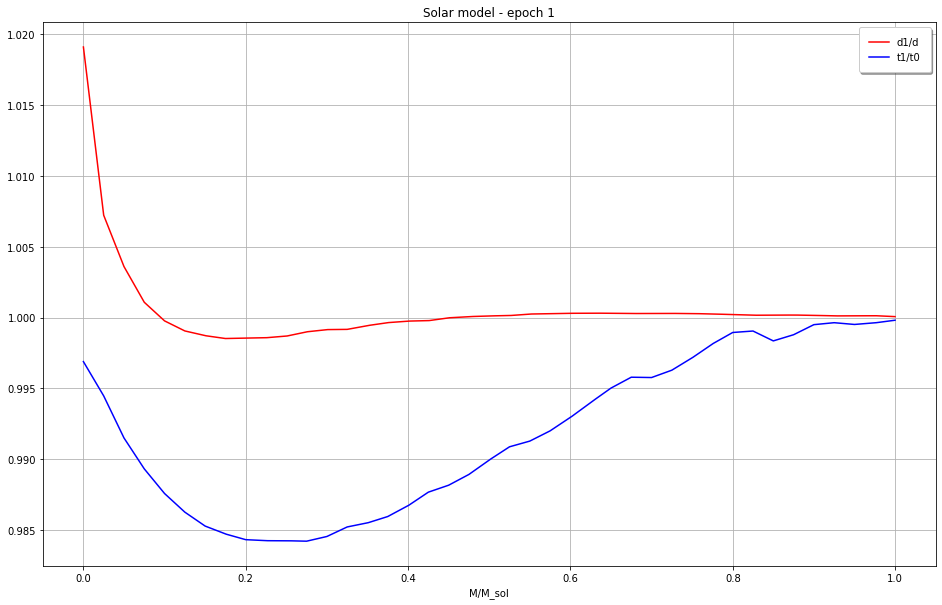

In [134]:
m1 = m/s.M
plt.figure(figsize=(16, 10))
ax = plt.axes()
# plt.plot(r1, c, color='black', label='Convection')
plt.plot(m1, d1/d, color='red', label='d1/d')
plt.plot(m1, t1/t, color='blue', label='t1/t0')
# plt.xlim(-0.1,0.1)
# plt.ylim(-0.1, 0.1)
plt.xlabel('M/M_sol')
plt.ylabel('')
plt.title('Solar model - epoch %d' % epoch)
ax.grid(b=True, which='both')
ax.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1);